# Question 3

In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from math import isnan

In [2]:
##Below code was taken from our lab

In [3]:
# undirected graph degree correlation
def deg_corr(G):
    idx = {v:k for k,v in enumerate([i for i in set(G.degree())])}
    idx_inv = {k:v for k,v in enumerate(idx)}
    deg = G.degree()
    L = [[] for i in range(len(idx))]
    for v in G.vs():
        # w = [deg[i] for i in list(set(G.neighbors(v)))] 
        w = [deg[i] for i in G.neighbors(v)] 
        L[idx[v.degree()]].extend(w)
    return {idx_inv[i]:np.mean(L[i]) for i in range(len(L))}

# degree correlation for neutral graphs: <k^2>/<k>
# to find uncorrelated knn
def deg_corr_neutral(G, mode='all'):
    x = G.degree(mode=mode)
    return np.mean([i**2 for i in x])/np.mean(x)   

# for a fixed l 
def richClub(g, l=1):
    g.vs()['degree'] = g.degree()
    l_max = np.max(g.degree())
    c = Counter(g.degree())
    n = g.vcount()
    moment = np.sum([k*c[k]/n for k in c])**2
    S = [k*c[k]/n for k in c if k>=l]
    phi_hat = np.sum([x*y for x in S for y in S])*g.ecount()/moment
    G = g.subgraph([v for v in g.vs() if v['degree']>=l])
    phi = G.ecount()
    return phi/phi_hat 


## Correlation exponent via linear regression (taking logs)
def corr_exp(G):
    ## compute knn's
    knn = deg_corr(G)
    
    try:
        # Fit the regression
        regressor = LinearRegression()  
        x = [np.log(i) for i in knn.keys()]
        y = [np.log(i) for i in knn.values()]
        regressor.fit(np.array(x).reshape(-1,1), y)
        return regressor.coef_[0]

    except:
        #removes NAN values
        knn = {key: knn[key] for key in knn if not isnan(knn[key])}
        
        # Fit the regression
        regressor = LinearRegression()  
        x = [np.log(i) for i in knn.keys()]
        y = [np.log(i) for i in knn.values()]
        regressor.fit(np.array(x).reshape(-1,1), y)
        return regressor.coef_[0]

In [4]:
## GitHub Developers (undirected)
D = pd.read_csv('musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
github_graph = ig.Graph.TupleList(tuples, directed = False)

## read node features
X = pd.read_csv('musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in github_graph.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
github_graph.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
github_graph.vs['color'] = [cls[i] for i in list(X['ml_target'])]
github_graph.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]


# building the subgraphs
github_graph_ml = github_graph.subgraph([v for v in github_graph.vs() if v['lbl']=='ml'])
github_graph_web = github_graph.subgraph([v for v in github_graph.vs() if v['lbl']=='web'])

# Number of nodes
print('GitHub nodes:',github_graph.vcount(),'; ml developers:',github_graph_ml.vcount(),'; web developers:',github_graph_web.vcount())


GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


In [5]:
# Number of edges
print('GitHub edges:',github_graph.ecount(),'; ml developers:',github_graph_ml.ecount(),'; web developers:',github_graph_web.ecount())


GitHub edges: 289003 ; ml developers: 19684 ; web developers: 224623


In [6]:
# removing loops

github_graph = github_graph.simplify(multiple=False)
github_graph_ml = github_graph_ml.simplify(multiple=False)
github_graph_web = github_graph_web.simplify(multiple=False)

# c = 0.5

In [7]:
# rewiring using rewire() function
# rewire(n=1000, mode='simple')
# n, is the number of trials
# mode='simple' does not create or destroy loops
# for the number of trials, I did number of edges * c (cm edge switching)

c = 0.5

github_graph2 = github_graph.copy()
github_graph2.rewire(round(github_graph.ecount()*c), mode='simple')

github_graph_ml2 = github_graph_ml.copy()
github_graph_ml2.rewire(round(github_graph_ml.ecount()*c), mode='simple')

github_graph_web2 = github_graph_web.copy()
github_graph_web2.rewire(round(github_graph_web.ecount()*c), mode='simple')

# Original Graph, c = 0.5

dotted horizontal line shows uncorrelated knn, which is  441.020594941921


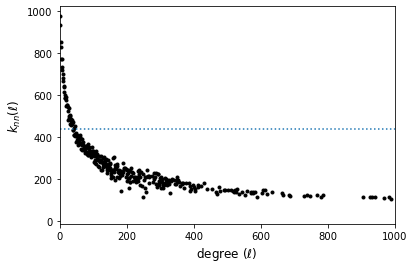

In [8]:
LIM = 1000 #degree limit for a clearer graph

knn = deg_corr(github_graph2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# ML Developers, c = 0.5

dotted horizontal line shows uncorrelated knn, which is  36.43680146311726


C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\G\anaconda3\envs\tensorflow_sessions\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


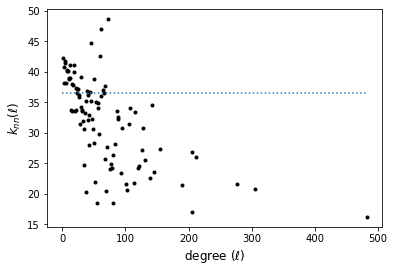

In [9]:
knn = deg_corr(github_graph_ml2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_ml2) #gives us uncorrelated knn


plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# Web Developers, c = 0.5

dotted horizontal line shows uncorrelated knn, which is  420.39156275181074


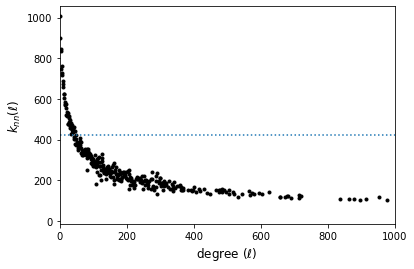

In [10]:
knn = deg_corr(github_graph_web2)

LIM = 1000 #degree limit for a clearer graph

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_web2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# c = 1

In [11]:
# rewiring using rewire() function
# rewire(n=1000, mode='simple')
# n, is the number of trials
# mode='simple' does not create or destroy loops
# for the number of trials, I did number of edges * c (cm edge switching)

c = 1

github_graph2 = github_graph.copy()
github_graph2.rewire(github_graph.ecount()*c, mode='simple')

github_graph_ml2 = github_graph_ml.copy()
github_graph_ml2.rewire(github_graph_ml.ecount()*c, mode='simple')

github_graph_web2 = github_graph_web.copy()
github_graph_web2.rewire(github_graph_web.ecount()*c, mode='simple')

# Original Graph, c = 1

dotted horizontal line shows uncorrelated knn, which is  441.020594941921


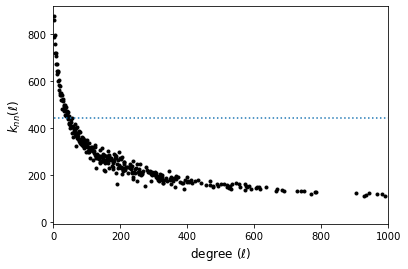

In [12]:
LIM = 1000 #degree limit for a clearer graph

knn = deg_corr(github_graph2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# ML Developers, c = 1

dotted horizontal line shows uncorrelated knn, which is  36.43680146311726


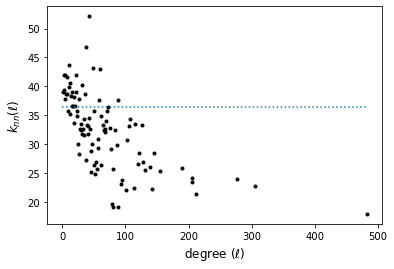

In [13]:
knn = deg_corr(github_graph_ml2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_ml2) #gives us uncorrelated knn


plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# Web Developers, c = 1

dotted horizontal line shows uncorrelated knn, which is  420.39156275181074


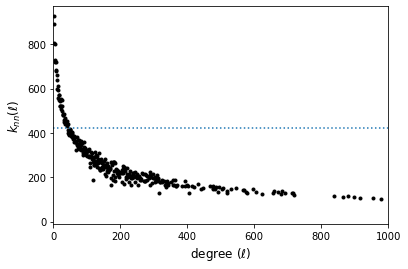

In [14]:
knn = deg_corr(github_graph_web2)

LIM = 1000 #degree limit for a clearer graph

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_web2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# c = 2

In [15]:
# rewiring using rewire() function
# rewire(n=1000, mode='simple')
# n, is the number of trials
# mode='simple' does not create or destroy loops
# for the number of trials, I did number of edges * c (cm edge switching)

c = 2

github_graph2 = github_graph.copy()
github_graph2.rewire(github_graph.ecount()*c, mode='simple')

github_graph_ml2 = github_graph_ml.copy()
github_graph_ml2.rewire(github_graph_ml.ecount()*c, mode='simple')

github_graph_web2 = github_graph_web.copy()
github_graph_web2.rewire(github_graph_web.ecount()*c, mode='simple')

# Original Graph, c = 2

dotted horizontal line shows uncorrelated knn, which is  441.020594941921


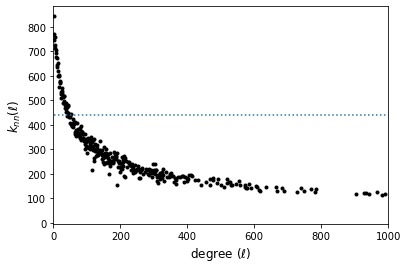

In [16]:
LIM = 1000 #degree limit for a clearer graph

knn = deg_corr(github_graph2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12);
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# ML Developers, c = 2

dotted horizontal line shows uncorrelated knn, which is  36.43680146311726


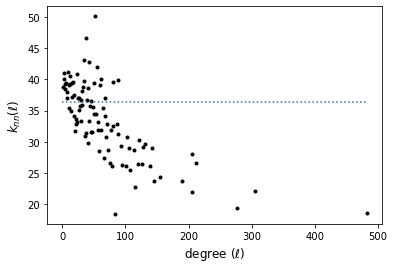

In [17]:
knn = deg_corr(github_graph_ml2)

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_ml2) #gives us uncorrelated knn


plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

# Web Developers, c = 2

dotted horizontal line shows uncorrelated knn, which is  420.39156275181074


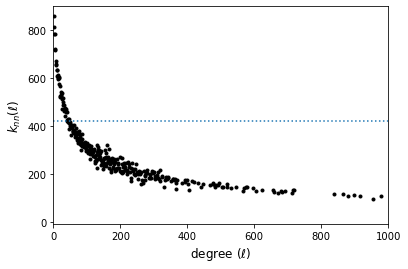

In [18]:
knn = deg_corr(github_graph_web2)

LIM = 1000 #degree limit for a clearer graph

x = list(knn.keys())
y = list(knn.values())

knn2 = deg_corr_neutral(github_graph_web2) #gives us uncorrelated knn

plt.xlim((0,LIM))
plt.scatter(x,y,marker='.',c='black')

plt.hlines(y=knn2,xmin=min(x),xmax=max(x),linestyles=':')
plt.xlabel(r'degree ($\ell$)',fontsize=12)
plt.ylabel(r'$k_{nn}(\ell)$',fontsize=12)
print("dotted horizontal line shows uncorrelated knn, which is ", knn2)

In [19]:
print("In conclusion, the rewired graphs are still not the same with original graphs, with cm edge rewirings. Again, this suggests github graphs are not uncorrelated.")

In conclusion, the rewired graphs are still not the same with original graphs, with cm edge rewirings. Again, this suggests github graphs are not uncorrelated.


# Alternative rewiring function

We also tried to build our own rewire function, we pass two arguments g(graph), and c(with 3 different values of cm). This functions rewires the edges and prints the count of numbers of edges switched then returns the graph so we can do futher computations.

In [22]:
def edge_switch(g,c):
    edge_lst = g.get_edgelist()
    m= g.ecount()
    loop_range = (m+1)//2
  
  
    count = 0
    for j  in range(c):
    
        # pick two random edges
        rnd1 = int(np.random.uniform(0,len(edge_lst)))
        edge1 = edge_lst[rnd1]
        #print(edge1)
        rnd2 = int(np.random.uniform(0,len(edge_lst)))
        edge2 = edge_lst[rnd2]
        #print(edge2)

        #switching the vertices of both the edges
        new_edge1 = (edge1[0],edge2[1])
        new_edge2 = (edge1[1],edge2[0])
        #print(new_edge1)
        #print(new_edge2)
        flag=False
        # add the switched vertices for the edge if these does not exit already
        for ed in g.get_edgelist():
            if ed==new_edge1 or ed== new_edge2:
                flag = True

        #print(flag)
        if flag == False:
            count +=1
            # Deleting the edges from the graph
            g.delete_edges(edge1)
            g.delete_edges(edge2)
            #print(g.ecount())
            g.add_edge(new_edge1[0],new_edge1[1])
            g.add_edge(new_edge2[0],new_edge2[1])
            #print(g.ecount())
        else:
            pass
    print("Number of switchings happened: ",count)
    return g
    
    


In [26]:
#c = [0.5,1,2]
#c1 = int(c[0]*github_graph.ecount())
#G  = edge_switch(github_graph,c1)
#c2 = int(c[1]*github_graph.ecount())
#c3 = int(c[2]*github_graph.ecount())